# Implementation of SoftTriple Loss

In this notebook, we present the implementation of the SoftTriple Loss defined in [1] by Qi Qian et al. The paper introduces also a regularization that enables an adaptive number of centers. We, hoever, don't implement the regularization part.

### Triple Loss

Triple Loss is a loss function used to learn a representation where similar images are closer than the different ones. It is, therefore, the basis for many applications in neural networks like word embeddings or metric learning. The triplet loss can be expressed mathematically as:

$ \forall i,j,k  \enspace ||\textbf{x}_i - \textbf{x}_k||_2^2 - ||\textbf{x}_i - \textbf{x}_j||_2^2 > \delta$

Here, $\textbf{x}_i$, $\textbf{x}_k$ are from the same class and $\textbf{x}_i$, $\textbf{x}_j$ belong to different classes. 

###  SoftTriple Loss

Recently, however, it has been shown by Qi Qian et al. in [1] that optimizing a smoothed triplet loss is equivalent to minimize a SoftMax loss. By using a mathematical formulation based on SoftMax, this loss eliminates the sampling needed in the triple loss (for picking the anchor, positve and negative image). Moreover, it extends the idea of multiple "centers", where the "centers" can be, for example, training samples (like in N-Shot learning). 





The authors define the *relaxed similarity* between the example $\textbf{x}_i$ and the class $c$ as follows:

$S^{'}_{i,c} = \sum_{k} \frac{\exp(\frac{1}{\gamma} \textbf{x}_i^{T}\textbf{w}_c^{k})}{\sum_{k} {\exp(\frac{1}{\gamma} \textbf{x}_i^{T}\textbf{w}_c^{k})}} \textbf{x}_i^T \textbf{w}_c^k$

Where $\textbf{w}_c$ are the weights associated to the class $c$ (and there are $k$ for them). For more details about the general derivation, we suggest to read the referenced paper [1]. However, it is important to notice that $\textbf{w}_c^k$ and $\textbf{x}_i$ are normalized, therefore the multiplicaiton between them corresponds to the cosine distance. 

On top of this formulation, they finally define the SoftTriple Loss as:

$l_{SoftTriple}(\textbf{x}_i) = -\log \frac{\exp(\lambda(S'_{i,y_i}-\delta))}{\exp(\lambda(S'_{i, y_i}-\delta))+\sum_{j \neq y_i} \exp(\lambda S'_{i,j})}$

This formulation makes the implementation in Tensorflow a bit tricky, that's why we reformulate the equation for the SoftTripleLoss as follows:

$l_{SoftTriple}(\textbf{x}_i) = -\log \frac{\exp(\lambda S^o_{i,y_i})}{\sum_{\forall j \in Class } \exp(\lambda S^o_{i,j})} = Softmax(\lambda S^o_{i, y_i})$

Where $y_i$ is the class of $\textbf{x}_i$, $Class$ is the set of all classes and $S^o_{i,j} = S'_{i,j}-\delta \mathbb{1}(y_i ==j)$. We also make some additional definitions that ease the coding of the loss:

* *Inner logits*: this is basically the multiplication between the inputs ($\textbf{x}_i$) and the centers ($\textbf{w}_c^k$). We can represent the set of inputs as a matrix $\textbf{X}\in \mathbb{R}^{N \times D}$. Morever, since there are $K$ different centers for every of $C$ clases, and every center $\textbf{w}_c^k\in \mathbb{R}^{ D}$, we represent the set of centers as a tensor $\textbf{W}\in \mathbb{R}^{K \times D \times C }$.
* *Inner softmax*: this corresponds to the Softmax that is involved in the calculation of the relaxed similarity.
* *Outer softmax*: this is the Softmax involved in the calculation of the total SofttripleLoss.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


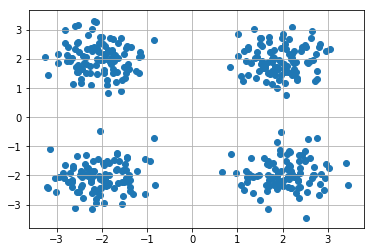

In [3]:
#creating artificial data

sd = 0.5
center1, center2 = -2, 2 
c1 = np.vstack( [np.random.normal(center1, sd, 100), np.random.normal(center1, sd, 100)]).T
c2 = np.vstack( [np.random.normal(center1, sd, 100), np.random.normal(center2, sd, 100)]).T
c3 = np.vstack( [np.random.normal(center2, sd, 100), np.random.normal(center2, sd, 100)]).T
c4 = np.vstack( [np.random.normal(center2, sd, 100), np.random.normal(center1, sd, 100)]).T
X = np.vstack((c1,c2,c3,c4))

y1 = np.repeat([[1,0]], 100,0)
y2 = np.repeat([[0,1]], 100,0)
y3 = np.repeat([[1,0]], 100,0)
y4 = np.repeat([[0,1]], 100,0)

Y = np.vstack((y1, y2, y3, y4))


plt.scatter(X[:,0], X[:,1])
plt.grid()

In [4]:
#creating the graph
gamma = 0.1
delta = 0.01
lamb = 2
alpha = 1
epochs = 100
learning_rate= 0.05

X_p =  tf.placeholder(tf.float32, shape=(None, None), name='input_y')
Y_p = tf.placeholder(tf.float32, shape=(None,None), name = 'labels')
W = tf.Variable(tf.truncated_normal(shape= [2, 2, 2], mean=0, stddev=0.01))

X_n = tf.math.l2_normalize(X_p, axis=1) 
W_n = tf.math.l2_normalize(W, axis=1)
inner_logits = tf.einsum('ie,kec->ikc', X_n, W_n)
inner_SoftMax = tf.nn.softmax((1/gamma)*inner_logits, axis=1)
s =  lamb*( tf.reduce_sum( tf.multiply(inner_SoftMax, inner_logits), axis=1) - delta*Y_p)
outer_SoftMax = tf.nn.softmax(s)
soft_triple_loss = -tf.reduce_sum(tf.log(tf.reduce_sum(tf.multiply(outer_SoftMax, Y_p), axis=1)))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(soft_triple_loss)

correct_pred = tf.equal(tf.argmax(outer_SoftMax, 1), tf.argmax(Y_p, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
#running the graph
with tf.Session() as sess:
    # Initializing the variables
   
    sess.run(tf.global_variables_initializer())
    
    feed_dict = {
                 X_p : X,
                 Y_p : Y}
    

    for e in range(epochs):
        _, stl, acc = sess.run([train_step, soft_triple_loss, accuracy], feed_dict = feed_dict)
        
        if e%10 == 0:
            print("Loss:", stl)
            print("Acc:", acc)
            
    [W_, correct_pred_ ]= sess.run([W,correct_pred], feed_dict = feed_dict)

Loss: 213.76772
Acc: 0.51
Loss: 143.21318
Acc: 0.88
Loss: 95.77054
Acc: 0.99
Loss: 78.758026
Acc: 1.0
Loss: 73.64248
Acc: 1.0
Loss: 71.695854
Acc: 1.0
Loss: 70.66887
Acc: 1.0
Loss: 70.16057
Acc: 1.0
Loss: 69.920654
Acc: 1.0
Loss: 69.78015
Acc: 1.0


# References

[1] Qi Qian et al. *SoftTriple Loss: Deep Metric Learning Without TripletSampling*. 2019. arXiv:1909.05235 